# bibliotēkas

In [58]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
import numpy as np
import scipy.sparse as sparse
import itertools
import copy
import implicit 
from implicit import evaluation
from datetime import datetime


def learning_curve(model, train, test, epochs, K=[3,5,10,20]):
    """
    Funkcija, kas pie katrām norādītajām modeļa trenēšanas iterācijām pārbauda modeļa rezultātu uz dotajiem K vienumiem,
    progresu saglabājot Pandas temp tabulā eval_metrics. 
    Funkciju bāze aizgūta no https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/
    """
    prev_epoch = 0
    eval_metrics=[]
    for epoch in epochs:
        print("Iterāciju skaits: {}".format(epoch))
        print(datetime.today())
        model.iterations = epoch - prev_epoch
        if not hasattr(model, 'user_vectors'):
            model.fit(train, show_progress=False)
        else:
            model.fit_partial(train, show_progress=False)
        for k in K:
            print("Testa vērtību skaits: {}".format(k))
            temp_items = evaluation.ranking_metrics_at_k(model, train, test, K=k, show_progress=False)
            temp_items["epoch"] = epoch
            temp_items["K"] = k
            eval_metrics.append(temp_items)
        prev_epoch = epoch
    return model, eval_metrics

def grid_search_learning_curve(base_model, train, test, param_grid,
                               epochs=range(2, 40, 2)):
    """
    funkcija, kas iterē caur parametru režģī norādītajām lambda un faktoru vērtībām,
    kā arī apkopo rezultātu pandas DF no learning_curve funkcijas rezultātiem. 
    Funkciju bāze aizgūta no https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/
    """
    curves = pd.DataFrame()
    keys, values = zip(*param_grid.items())
    for v in itertools.product(*values):
        params = dict(zip(keys, v))
        this_model = copy.deepcopy(base_model)
        print_line = []
        for k, v in params.items():
            setattr(this_model, k, v)
            print_line.append((k, v))

        print(' | '.join('{}: {}'.format(k, v) for (k, v) in print_line))
        mod, eval_metrics = learning_curve(this_model, train, test,epochs)
        temp_table = pd.DataFrame(eval_metrics)
        for  (k, v) in print_line:
            temp_table[k] = v
        curves=curves.append(temp_table)
    return curves

# Datu ielasīšana un matricu konstruēšana

In [59]:
#datu ielāde
df = pd.read_csv(r"\Train\user_watched.csv")
df.rename(columns={"movieid":"movieId","userid":"userId"},inplace=True)

In [60]:
#datu paraugs
df.head()

,movieId,userId,rating
0,путевка в жизнь,DTVS0352660,1
1,сказка о потерянном времени,DTVS0196936,1
2,girl in progress,DTVS0444587,1
3,stikla pils,DTVS0291378,1
4,tomasa krauna afera,DTVS0076064,1


In [61]:
#dublikātu nomešana
df.drop_duplicates(subset=['movieId', 'userId', 'rating'],inplace=True)

In [62]:
#string tipa vērtību transformēšana par skaitliskām vērtībām
df['movieId'] = df['movieId'].astype("category")
df['movieId'] = df['movieId'].cat.as_ordered()
df['userId'] = df['userId'].astype("category")
df['userId'] = df['userId'].cat.as_ordered()
df['movie_Id'] = df['movieId'].cat.codes
df['user_Id'] = df['userId'].cat.codes

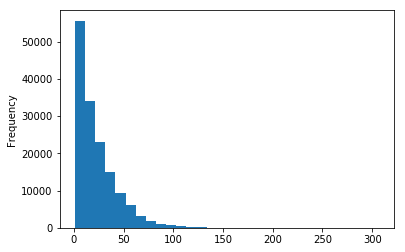

In [63]:
#Lietotāju interakciju skaita histogramma
df['userId'].value_counts().plot(kind = 'hist',bins=30)

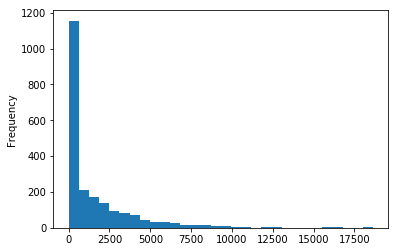

In [64]:
#Filmu interakciju skaita histogramma
df['movieId'].value_counts().plot(kind = 'hist',bins=30)

In [65]:
#kopējais vērtējumu skaits
df.shape

(3427277, 5)

In [66]:
#lietotāju skaits ar vismaz diviem vērtējumiem
df_cnt=df.groupby('userId')['rating'].count().reset_index()
print(df_cnt.shape, df_cnt[df_cnt.rating>2].shape)

(151077, 2) (137748, 2)


In [67]:
#unikālo filmu un lietotāju skaits
movies=df[['movieId','movie_Id']].drop_duplicates()
users=df[['userId','user_Id']].drop_duplicates()
print(movies.shape,users.shape)

(2152, 2) (151077, 2)


In [68]:
#matrix sparsity check
mat_sparsity=round((1-df.shape[0]/(movies.shape[0]*users.shape[0]))*100,2)
print(mat_sparsity)

98.95


In [69]:
print('matricas aizpildījums:', round(100-mat_sparsity,2))

matricas aizpildījums: 1.05


In [70]:
#reti aizpildīto matricu konsturēšana no pandas DF
sparse_item_user = sparse.csr_matrix((df['rating'].astype(float), (df['movie_Id'], df['user_Id'])))
sparse_user_item = sparse.csr_matrix((df['rating'].astype(float), (df['user_Id'], df['movie_Id'])))

# Modeļa parametru pārmeklēšana

In [71]:
#testa kopas izveidošana - visiem lietotājiem, kuriem ir vismaz divas filmas, vienu izmanotojam testēšanai
data_conf_train,data_conf_test=evaluation.leave_k_out_split(sparse_user_item, K=2, train_only_size=0.0, random_state=42)

In [78]:
param_grid = {'factors': [12],
              'regularization': [1e-1]}

In [79]:
# modeļa trenēšana ar definēto parametru režģi
model=implicit.als.AlternatingLeastSquares()
curves = grid_search_learning_curve(model, data_conf_train, data_conf_test,
                                    param_grid=param_grid)

factors: 12 | regularization: 0.1
Iterāciju skaits: 2
2022-05-19 20:52:15.378481
Testa vērtību skaits: 3
Testa vērtību skaits: 5
Testa vērtību skaits: 10
Testa vērtību skaits: 20
Iterāciju skaits: 4
2022-05-19 20:53:52.277648
Testa vērtību skaits: 3
Testa vērtību skaits: 5
Testa vērtību skaits: 10
Testa vērtību skaits: 20
Iterāciju skaits: 6
2022-05-19 20:55:28.992100
Testa vērtību skaits: 3
Testa vērtību skaits: 5
Testa vērtību skaits: 10
Testa vērtību skaits: 20
Iterāciju skaits: 8
2022-05-19 20:57:06.776387
Testa vērtību skaits: 3
Testa vērtību skaits: 5
Testa vērtību skaits: 10
Testa vērtību skaits: 20
Iterāciju skaits: 10
2022-05-19 20:58:43.413139
Testa vērtību skaits: 3
Testa vērtību skaits: 5
Testa vērtību skaits: 10
Testa vērtību skaits: 20
Iterāciju skaits: 12
2022-05-19 21:00:20.014173
Testa vērtību skaits: 3
Testa vērtību skaits: 5
Testa vērtību skaits: 10
Testa vērtību skaits: 20
Iterāciju skaits: 14
2022-05-19 21:01:58.854982
Testa vērtību skaits: 3
Testa vērtību skaits: 

# Modeļa trenēšana ar labākajiem parametriem un rezultātu pielasīšana

In [86]:
#Modeļa veidošana
model = implicit.als.AlternatingLeastSquares(factors= 12, regularization=0.01, iterations=22,
                                                  calculate_training_loss=True,random_state=42)

model.fit(data_conf_train)

  0%|          | 0/22 [00:00<?, ?it/s]

In [73]:
#precizitātes pārbaude pie dažādām k vērtībām (top k elementos tiek meklēts leave one out testa kopas vienums)

In [74]:
evaluation.ranking_metrics_at_k(model, data_conf_train, data_conf_test, K=3)

  0%|          | 0/132236 [00:00<?, ?it/s]

{'precision': 0.08222042409026287,
 'map': 0.05915307984714511,
 'ndcg': 0.07784373485049531,
 'auc': 0.5404597154345165}

In [75]:
evaluation.ranking_metrics_at_k(model, data_conf_train, data_conf_test, K=5)

  0%|          | 0/132236 [00:00<?, ?it/s]

{'precision': 0.11337684140476119,
 'map': 0.0672420268812381,
 'ndcg': 0.09348129604238749,
 'auc': 0.555603976540302}

In [76]:
evaluation.ranking_metrics_at_k(model, data_conf_train, data_conf_test, K=10)

  0%|          | 0/132236 [00:00<?, ?it/s]

{'precision': 0.17217701684866452,
 'map': 0.07639400090123045,
 'ndcg': 0.11662363691801977,
 'auc': 0.5839350945490382}

In [77]:
evaluation.ranking_metrics_at_k(model, data_conf_train, data_conf_test, K=20)

  0%|          | 0/132236 [00:00<?, ?it/s]

{'precision': 0.25621615898847516,
 'map': 0.08359953874965272,
 'ndcg': 0.14255024820268328,
 'auc': 0.623886036734279}

In [81]:
users

,userId,user_Id
0,DTVS0352660,96736
1,DTVS0196936,49586
2,DTVS0444587,130693
3,DTVS0291378,77396
4,DTVS0076064,17765
...,...,...
3540739,DTVS0094038,22312
3541331,DTVS0246564,64238
3542670,DTVS0033967,7111
3542752,DTVS0187147,46683


In [91]:
#Get Recommendations
user_id =  [119283,49586]
recommended = model.recommend(userid=user_id,user_items=sparse_item_user,N=50,filter_already_liked_items=False,recalculate_user=False)
print(recommended)

(array([[ 249, 1688,  903, 1352,  216,  461,  460,  462,  911,  912, 1078,
         616,  541,  618,  871, 1340,  617,  631,  842,  615,  200, 1491,
        1417, 1107, 1190,  208, 1591,  841,  287, 1558,  986, 1189, 1471,
        1409,  160,  430, 1522,  792, 1290,  540,  338, 1557,   71, 1441,
        1521, 1508, 1274, 1449, 1114, 1161],
       [2016, 1947, 1836, 2060, 2056, 2144, 2055, 2059, 1977, 1730, 1683,
        2057, 2039, 1999, 1927, 1982, 2052, 2061, 2058, 1734, 2023, 1929,
        1535, 2028, 1840, 1910, 1930, 1905, 1949, 1843, 1966, 1862, 2123,
        1981, 1679, 2079, 1372, 1915, 2077, 2025, 1053, 1232,  230, 1855,
        1108, 1010, 1998, 1837,    5,  257]]), array([[0.99474436, 0.81607765, 0.8156618 , 0.7819611 , 0.701508  ,
        0.68843764, 0.6829323 , 0.5907436 , 0.5712441 , 0.43912268,
        0.43801022, 0.42675352, 0.3488519 , 0.31185046, 0.30289644,
        0.29799676, 0.29748458, 0.29153904, 0.27990425, 0.27813032,
        0.27670535, 0.27266198, 0.27174103,

In [92]:
# datu transformēšana no ieteikto vienumu un ieteikumu koeficienta masīviem uz pandas DF
r=pd.DataFrame(zip(recommended[0],recommended[1],user_id),columns=['movie_Id','value','user_Id'])
r2=r.set_index(['user_Id']).apply(pd.Series.explode).reset_index()

r3=r2.merge(movies,how='inner',left_on='movie_Id', right_on='movie_Id')
rek2=r3.merge(users,how='inner',left_on='user_Id', right_on='user_Id')
rek3=pd.merge(rek2,df[['movie_Id','user_Id','rating']],on=['movie_Id','user_Id'],how='left')

In [93]:
#unikālo ieteikumu skaits, ko modelis ģenerē pie N ieteikumiem
rek3['movie_Id'].nunique()

100

# Līdzīgo filmu atrašana

In [94]:
#līdzīgo filmu pielasīšana
item_id = 192
n_similar = 10
similar = model.similar_items(item_id, n_similar)
print(similar)

(array([ 192, 1630, 1306,   99,  144,  314,   76, 1705,  143,  252]), array([1.0000001 , 0.95118546, 0.9511664 , 0.9499045 , 0.9495225 ,
       0.94149995, 0.9284484 , 0.9264    , 0.9178891 , 0.9162155 ],
      dtype=float32))


In [95]:
#līdzīgo filmu piemērs
similar_mov=pd.DataFrame(zip(similar[0],similar[1]),columns=['movie_Id','value'])
similar_mov.merge(movies,how='inner',on='movie_Id')

,movie_Id,value,movieId
0,192,1.000000,bill & ted face the music
1,1630,0.951185,war for the planet of the apes
2,1306,0.951166,terminator dark fate
3,99,0.949905,ant man and the wasp
4,144,0.949522,avengers infinity war
5,314,0.941500,dark phoenix
6,76,0.928448,alita battle angel
7,1705,0.926400,агрессивная среда звук
8,143,0.917889,avengers endgame
9,252,0.916215,captain marvel
